In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1 for disable CUDA


import numpy as np
import tensorflow as tf
import csv
CSV_DATA = "daily-min-temp.csv"

In [7]:
time_step = []
temps = []

with open(CSV_DATA) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step=step + 1

series = np.array(temps)
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [3]:
# # Normalizing series (in certification preparation)
# min=np.min(series)
# max=np.max(series)
# series -= min
# series /= max
# series

In [4]:
# Normalizing series (it's min-max scaling right?) Yep...
min=np.min(series)
max=np.max(series)
series = (series - min) / (max - min)
series

array([0.78707224, 0.68060837, 0.7148289 , ..., 0.51330798, 0.59695817,
       0.49429658])

In [5]:
# DO NOT CHANGE THIS CODE
split_time=2500
x_train=series[:split_time]
x_valid=series[:split_time]

In [6]:
# DO NOT CHANGE THIS CODE
window_size=64
batch_size=256
shuffle_buffer_size=1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

train_set=windowed_dataset(
        x_train, window_size, batch_size, shuffle_buffer_size)
test_set=windowed_dataset(
        x_valid, window_size, batch_size, shuffle_buffer_size)

In [7]:
# Only work for one feature
def window_set(series, window_size):
    max_datasets = len(series) - window_size
    series = series.reshape((-1, 1))
    x = np.asarray([series[i:window_size+i] for i in range(max_datasets)])
    y = np.asarray([series[window_size+i] for i in range(max_datasets)]).reshape(-1)
    return x, y

x, y = window_set(x_train, window_size)
x_val, y_val = window_set(x_valid, window_size)

In [8]:
main_model=tf.keras.models.Sequential([
            # YOUR CODE HERE.
            tf.keras.layers.Input(shape=(window_size, 1)),
            tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                                strides=1, padding="causal",
                                activation="relu"),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(30, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
    ])

In [9]:
class TargetCallbacks(tf.keras.callbacks.Callback):
    MAX_CONSECUTIVE = 10
    consecutive_target = 0

    target = "mean_absolute_error"
    val_target ="val_mean_absolute_error"

    desired = 0.19

    def on_epoch_end(self, epoch, logs=None):
        if (logs[self.target] < self.desired) and (logs[self.val_target] < self.desired):
            self.consecutive_target += 1
            if self.consecutive_target >= 5:
                self.model.stop_training=True
        else:
            self.consecutive_target = 0

def create_model(model, weights):
    model1=tf.keras.models.clone_model(model)
    model1.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=["mean_absolute_error"])
    model1.set_weights(weights)
    
    model2=tf.keras.models.clone_model(model)
    model2.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=["mean_absolute_error"])
    model2.set_weights(weights)
    return model1, model2

In [10]:
model1, model2 = create_model(main_model, main_model.get_weights())
# Check if points to same model
print(hex(id(model1)))
print(hex(id(model2)))

0x1e93e9233d0
0x1e93e9b4fa0


In [11]:
# My own preprocessing
tf.random.set_seed(2022)
model1.fit(x, y, epochs=100, shuffle=True, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[TargetCallbacks()])

Epoch 1/100
10/10 [==============================] - 12s 529ms/step - loss: 0.0765 - mean_absolute_error: 0.3581 - val_loss: 0.0255 - val_mean_absolute_error: 0.1921
Epoch 2/100
10/10 [==============================] - 4s 455ms/step - loss: 0.0152 - mean_absolute_error: 0.1401 - val_loss: 0.0087 - val_mean_absolute_error: 0.1027
Epoch 3/100
10/10 [==============================] - 5s 467ms/step - loss: 0.0096 - mean_absolute_error: 0.1086 - val_loss: 0.0086 - val_mean_absolute_error: 0.1026
Epoch 4/100
10/10 [==============================] - 5s 473ms/step - loss: 0.0084 - mean_absolute_error: 0.1016 - val_loss: 0.0081 - val_mean_absolute_error: 0.0996
Epoch 5/100
10/10 [==============================] - 5s 463ms/step - loss: 0.0080 - mean_absolute_error: 0.0984 - val_loss: 0.0077 - val_mean_absolute_error: 0.0963
Epoch 6/100
10/10 [==============================] - 5s 481ms/step - loss: 0.0075 - mean_absolute_error: 0.0950 - val_loss: 0.0071 - val_mean_absolute_error: 0.0926


In [12]:
tf.random.set_seed(2022)
model2.fit(train_set, epochs=100, validation_data=test_set, callbacks=[TargetCallbacks()])

Epoch 1/100
10/10 [==============================] - 15s 792ms/step - loss: 0.0781 - mean_absolute_error: 0.3610 - val_loss: 0.0267 - val_mean_absolute_error: 0.1968
Epoch 2/100
10/10 [==============================] - 5s 521ms/step - loss: 0.0158 - mean_absolute_error: 0.1451 - val_loss: 0.0083 - val_mean_absolute_error: 0.1008
Epoch 3/100
10/10 [==============================] - 5s 528ms/step - loss: 0.0100 - mean_absolute_error: 0.1106 - val_loss: 0.0085 - val_mean_absolute_error: 0.1020
Epoch 4/100
10/10 [==============================] - 5s 522ms/step - loss: 0.0086 - mean_absolute_error: 0.1033 - val_loss: 0.0081 - val_mean_absolute_error: 0.0994
Epoch 5/100
10/10 [==============================] - 5s 498ms/step - loss: 0.0078 - mean_absolute_error: 0.0975 - val_loss: 0.0076 - val_mean_absolute_error: 0.0955
Epoch 6/100
10/10 [==============================] - 5s 496ms/step - loss: 0.0073 - mean_absolute_error: 0.0942 - val_loss: 0.0069 - val_mean_absolute_error: 0.0912


In [13]:
a = model1.predict(x_val)
b = model2.predict(x_val)

77/77 [==============================] - 3s 21ms/step


In [14]:
a_reshaped = a.reshape(-1)
b_reshaped = b.reshape(-1)

In [15]:
import matplotlib.pyplot as plt

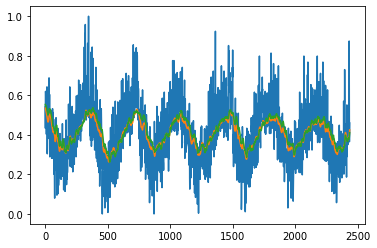

In [16]:
plt.plot(y_val)
plt.plot(a_reshaped)
plt.plot(b_reshaped)

In [17]:
model1.evaluate(test_set)
model2.evaluate(test_set)

10/10 [==============================] - 1s 86ms/step - loss: 0.0069 - mean_absolute_error: 0.0912


[0.006886390503495932, 0.09123699367046356]

In [18]:
model1.evaluate(x_val, y_val)
model2.evaluate(x_val, y_val)

77/77 [==============================] - 3s 15ms/step - loss: 0.0077 - mean_absolute_error: 0.0965


[0.007725842297077179, 0.09650137275457382]